# Download modules

In [6]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=099dea530018f871e52454ba7303cdc5182262c37f6fc9783436ae5671e0a651
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=32247bf91797e8722e5c012776eb670ee525e83434a8e74c80e8833b6fd7e280
  Stored in directory: /root/.cache/pip/wheels/d1/3b/4e/2f3015f1ab76f34be28e04c4bcee27e8cabfa70d2eadf8bc3b
Successfully built efficientnet-pytorch pretrainedmodels


In [16]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 MB 24.6 MB/s eta 0:00:0000:0100:01


In [18]:
!pip install nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.4 MB/s eta 0:00:0000:0100:01


In [19]:
import numpy as np
from time import time
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch
import os
import segmentation_models_pytorch as smp

import os
import SimpleITK as sitk
import nibabel as nib
from pathlib import Path
import re
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import csv

In [37]:
import os
import SimpleITK as sitk
import nibabel as nib
from pathlib import Path
import re
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import csv

# Function to load yaml configuration file
def load_config(config_name):
    """
    Load configuration file
    :param config_name:
    :return: configuration data
    """
    with open(config_name) as file:
        config = yaml.safe_load(file)

    return config


def load_mask(file):
    """
    Load masks from .gz files

    :param file: input filename
    :return: array of 2D masks (z, x, y)
    """
    mask = nib.load(file)
    mask = mask.get_fdata().transpose(2, 0, 1)
    mask = np.rot90(mask, axes=(1, 2))
    mask = mask.astype('int')

    return mask


def load_dicom(directory):
    """
    Load images from .dcm files

    :param directory: directory with .dcm files
    :return: array of 2D images (z, x, y)
    """
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image_itk = reader.Execute()
    image_zyx = sitk.GetArrayFromImage(image_itk).astype(np.int16)
    image_zyx = image_zyx.astype('int')

    return image_zyx


def preprocess_dataset(dir_original_images,
                       dir_original_masks,
                       dir_processed, save=True, output=False):
    """
    Load original images and masks from input directories
    and store them as numpy arrays

    :param dir_original_images: directory with input images
    :param dir_original_masks: directory with input masks
    :param dir_processed: directory for processed data
    :param save: save processed images and masks to .npz files and file with meta-data
    :param output: output processed images and masks

    :return array of images (z, x, y) and masks (z, x, y) if param output=True
    """

    images = np.empty(shape=(0, 512, 512)).astype('int')
    masks = np.empty(shape=(0, 512, 512)).astype('int')

    images_folders = [str(name) for name in
                      list(Path(os.path.join(dir_original_images)).rglob("**"))
                      if os.listdir(name)[0].endswith('.dcm')]

    masks_values = []

    for folder in images_folders:

        images = np.concatenate((images, load_dicom(folder)), axis=0)

        patient = re.findall(r'LUNG[0-9]*-[0-9]*', folder)[0]

        mask_file = str(list(Path(os.path.join(dir_original_masks, patient))
                             .rglob("*.gz"))[0])

        masks_batch = load_mask(mask_file)

        if save:
            masks_values = masks_values + [[patient, 1] if mask.sum() > 0 else [patient, 0]
                                           for mask in masks_batch]

        masks = np.concatenate((masks, masks_batch), axis=0)

    print(f'Images read: {images.shape[0]}')
    print(f'Masks read: {masks.shape[0]}')

    if save:
        np.savez_compressed(os.path.join(dir_processed, 'images'), *[image for image in images])
        np.savez_compressed(os.path.join(dir_processed, 'masks'), *[mask for mask in masks])

        masks_df = pd.DataFrame(data=masks_values, columns=['Patient', 'Effusion'])

        masks_df.to_csv(os.path.join(dir_processed, 'meta_file.csv'),
                        sep='\t', index_label='index')

    if output:
        return images, masks


def show_dice_example(mask1, mask2, dice_coef):
    """
    Show plots with two binary masks and dice coefficient between them
    :param mask1:  binary mask [n, z, x, y]
    :param mask2: binary mask [n, z,  x, y]
    :param dice_coef: dice coefficient
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    plt.suptitle(f'DICE coefficient: {dice_coef:.2f}')

    ax[0].imshow(mask1[0].permute(1, 2, 0))
    ax[1].imshow(mask2[0].permute(1, 2, 0))

    ax[0].set_title('Mask 1')
    ax[1].set_title('Mask 2')

    plt.show()


def save_history(history_dict, output_folder):
    """
    Save training history file to csv
    :param history_dict:  dictionary with training history
    :param output_folder:  folder to write csv
    """
    try:
        pd.DataFrame(history_dict).to_csv(os.path.join(output_folder, 'train_history.csv'),
                                          index_label='epoch', sep='\t', float_format='%.3f')
    except IOError:
        print("I/O error")



def  save_dice_image(epoch, dice, output_dir):
    """
    # Save plot of dice coefficient over epoch
    :param epoch:  current epoch
    :param dice:  dice coefficient value
    :param: output_dir: output folder
    """

    epochs = [i+1 for i in range(epoch+1)]
    plt.plot(epochs, dice)
    plt.title('DICE coefficient for validation set')
    plt.xlabel('Epoch')
    plt.ylabel('DICE coef')
    plt.ylim(0, 1)
    plt.xlim(1, epoch+1)
    plt.xticks(epochs)
    plt.grid(visible=True)
    plt.savefig(os.path.join(output_dir, 'DICE_coef.png'))


In [10]:
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T


class ImageDataset(Dataset):
    def __init__(self, dir_input, test_size, is_valid=None, normalization=None):
        """
        Initialize images and masks datasets
        :param dir_input: directory with input data
        :param test_size: size of validation dataset
        :param is_valid: defines validation or training set
        :param normalization: normalization to be applied to input images
        """

        # Read images
        self.images = np.load(os.path.join(dir_input, 'images.npz'))

        # Read masks
        self.masks = np.load(os.path.join(dir_input, 'masks.npz'))

        # Read meta-file
        self.meta = pd.read_csv(os.path.join(dir_input,
                                             'meta_file.csv'), sep='\t')

        # Split data into train and validation sets if necessary
        if is_valid:
            idx_train, idx_val, _, _ = train_test_split(self.meta['index'].values,
                                                        self.meta['Effusion'].values,
                                                        test_size=test_size,
                                                        random_state=42)
            if is_valid == True:
                self.meta = self.meta.iloc[idx_val]
            else:
                self.meta = self.meta.iloc[idx_train]

        if normalization:
            self.normalization = T.Normalize(std=443, mean=-720)

    def __getitem__(self, idx):
        """
        Get item from dataset according to index from meta-file
        :param idx: index
        """
        index = 'arr_' + str(self.meta.iloc[idx]['index'])

        mask = T.ToTensor()(self.masks[index]).type(torch.float)
        image = T.ToTensor()(self.images[index]).type(torch.float)

        if self.normalization:
            image = self.normalization(image)

        return image, mask

    def __len__(self):
        """
        Get length of dataset
        """
        return len(self.meta)


In [11]:
import torch
import torch.nn.functional as F
from torch.nn import Conv2d, ReLU, ConvTranspose2d, MaxPool2d, Module, ModuleList
from torchvision.transforms import CenterCrop


class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()

        # Convolution and RELU layers
        self.conv1 = Conv2d(inChannels, outChannels, 3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels, outChannels, 3)

    def forward(self, x):
        # apply CONV => RELU => CONV block to the inputs and return it
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(Module):
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()

        # Eencoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])

        self.pool = MaxPool2d(2)

    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []

        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs


class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and
        # decoder blocks
        self.channels = channels
        self.upconvs = ModuleList(
            [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
             for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList(
            [Block(channels[i], channels[i + 1])
             for i in range(len(channels) - 1)])

    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            # concatenate them with the current upsampled features,
            # and pass the concatenated output through the current
            # decoder block
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        # return the final decoder output
        return x

    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, and crop the encoder
        # features to match the dimensions
        (_, _, H, W) = x.shape
        encFeatures = CenterCrop([H, W])(encFeatures)
        # return the cropped features
        return encFeatures


class UNet(Module):
    def __init__(self, outSize, encChannels=(1, 16, 32, 64),
                 decChannels=(64, 32, 16),
                 nbClasses=1, retainDim=True):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)

        # initialize the regression head and store the class variables
        self.head = Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)

        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0],
                                   encFeatures[::-1][1:])

        # pass the decoder features through the regression head to
        # obtain the segmentation mask
        map = self.head(decFeatures)

        # check to see if we are retaining the original output
        # dimensions and if so, then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)

        # return the segmentation map
        return map


In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

def dice_coefficient(mask1, mask2):
    """
    Calculate DICE coefficient between masks in batch
    :param mask1: predicted mask
    :param mask2: ground truth mask
    :return: DICE coefficient
    """

    # Calculate  summary area for each masks
    sum1 = mask1.sum(axis=(1, 2, 3))
    sum2 = mask2.sum(axis=(1, 2, 3))

    # Calculate intersection
    intersection = (mask1 * mask2).sum(axis=(1, 2, 3))

    #  Calculate mean dice coefficient (set value to 1 if both masks are empty)
    coefficient = (2 * intersection / (sum1 + sum2)).nan_to_num(1.).mean().item()

    return  coefficient


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a sigmoid or equivalent activation layer

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice




In [43]:
config = {'dataset': 
          {'dir_images': 'data/raw/images/', 
           'dir_masks': 'datsets/data/raw/masks/', 
           'dir_processed': '/datasets/pleural-effusion/', 
           'image_height': 512, 
           'image_width': 512}, 
          
          'model': {'architecture': 'UNet', 
                    'dir_output': 'ouput/'}, 
          
          'train': {'test_size': 0.2, 
                    'batch_size': 8, 
                    'device': 'cuda', 
                    'learning_rate': 2e-05, 
                    'beta1': 0.9, 'beta2': 0.999, 
                    'num_epochs': 3, 
                    'decay_rate': 1}, 
          
          'evaluate': {'batch_size': 8, 
                       'device': 'cuda', 
                       'threshold': 0.5}}


In [27]:
# Create train dataset
train_dataset = ImageDataset(dir_input=config['dataset']['dir_processed'],
                             test_size=config['train']['test_size'],
                             is_valid=False,
                             normalization=True)

# Create validation dataset
valid_dataset = ImageDataset(dir_input=config['dataset']['dir_processed'],
                             test_size=config['train']['test_size'],
                             is_valid=True,
                             normalization=True)

# Create dataloader for train dataset
train_dataloader = DataLoader(train_dataset,
                              batch_size=config['train']['batch_size'],
                              shuffle=True)

# Create dataloader for validation dataset
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=config['evaluate']['batch_size'],
                              shuffle=False)

In [40]:


# Define model
net = UNet(outSize=(config['dataset']['image_height'],
                        config['dataset']['image_width'])).to(config['train']['device'])

# net.load_state_dict(torch.load('output/model_state_final_6.ckpt'))

# Define loss function
criterion  =   smp.losses.DiceLoss(mode='binary')

# Define optimizer
optimizer = Adam(net.parameters(),
                 lr=config['train']['learning_rate'],
                 betas=(config['train']['beta1'], config['train']['beta2']))

# Define learning rate scheduler
lambda_decay = lambda epoch: config['train']['decay_rate'] ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_decay)

print("[INFO] Training begin...")

# Collect training results
history = {}
history['train_loss'] = []
history['train_dice'] = []
history['valid_loss'] = []
history['valid_dice'] = []

best_loss_score = np.Inf
epochs = config['train']['num_epochs']
start_time = time()

# Iterate through epoches
for epoch in range(epochs):
    # Set network to train mode
    net.train()

    # Initialize train and validation losses and dice values for an epoch
    train_loss_total = 0
    valid_loss_total = 0
    train_dice_total = 0
    valid_dice_total = 0

    # Check learning rate
    learning_rate = optimizer.param_groups[0]["lr"]

    # Iterate through dataloader
    for (image, mask) in train_dataloader:
        # Send input to device
        image = image.to(config['train']['device'])
        mask = mask.to(config['train']['device'])

        # Make prediction
        pred = net(image)

        # Calculate loss
        loss = criterion(pred, mask)

        # Zero previous gradient
        optimizer.zero_grad()

        # Perform backpropagation
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Add loss
        train_loss_total += loss.item()

        # Add dice value
        pred_mask = (torch.sigmoid(pred) > config['evaluate']['threshold'])
        train_dice_total += dice_coefficient(pred_mask.detach().cpu(), mask.detach().cpu())
        break

    # Turn off autogradient
    with torch.no_grad():

        # Set model to evaluation mode
        net.eval()

        # Iterate through dataloader
        for (image, mask) in valid_dataloader:
            # Send input to device
            image = image.to(config['train']['device'])
            mask = mask.to(config['train']['device'])

            # Make prediction
            pred = net(image)

            # Calculate loss
            loss = criterion(pred, mask)

            # Add loss
            valid_loss_total += loss.item()

            # Add dice value
            pred_mask = (torch.sigmoid(pred) > config['evaluate']['threshold'])
            valid_dice_total += dice_coefficient(pred_mask.detach().cpu(), mask.detach().cpu())
            break

    # Step learning rate scheduler
    scheduler.step()

    # Calculate average loss and dice per epoch
    avg_train_loss = train_loss_total / (len(train_dataloader))
    avg_valid_loss = valid_loss_total / (len(valid_dataloader))
    avg_train_dice = train_dice_total / (len(train_dataloader))
    avg_valid_dice = valid_dice_total / (len(valid_dataloader))

    # Check if loss on current epoch is the best
    if avg_valid_loss < best_loss_score:
        best_loss_score = avg_valid_loss
        torch.save(net.state_dict(),
                   os.path.join(config['model']['dir_output'],
                                'model_state_best.ckpt'))

        
    # Update training results
    history['train_loss'].append(avg_train_loss)
    history['valid_loss'].append(avg_valid_loss)
    history['train_dice'].append(avg_train_dice)
    history['valid_dice'].append(avg_valid_dice)

    save_dice_image(epoch, history['valid_dice'], config['model']['dir_output'])
    
    
    # Print epoch results
    print('Epoch %3d/%3d, train loss: %5.3f, val loss: %5.3f, train dice: %5.3f, val dice: %5.3f, lr: %5.7f' % \
          (epoch + 1, epochs, avg_train_loss, avg_valid_loss, avg_train_dice, avg_valid_dice, learning_rate))

# Save history file
save_history(history, output_folder=config['model']['dir_output'])

# Print time statistics
end_time = time()
print()
print('Time total:     %5.2f sec' % (end_time - start_time))
print('Time per epoch: %5.2f sec' % ((end_time - start_time) / epochs))
print()

torch.save(net.state_dict(),
           os.path.join(config['model']['dir_output'],
                        'model_state_final_v1.ckpt'))

print("[INFO] Training complete")

[INFO] Training begin...


FileNotFoundError: [Errno 2] No such file or directory: '/notebooks/ouput/model_state_best.ckpt'

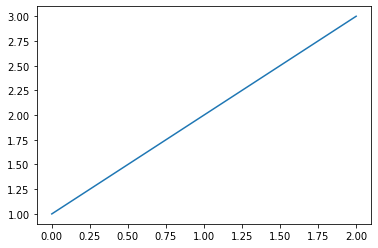

In [42]:
import matplotlib.pyplot as plt

plt.plot([1,2,3])
plt.savefig('output/temp.png')